In [51]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchsummary import summary

import numpy as np

import matplotlib.pyplot as plt

In [27]:
def generate_data(func, n_samples=100, n_dim=2):
    # Generate data in the form of a 2D tensor for neural network input
    X = torch.linspace(0, 1, n_samples * n_dim).view(n_samples, n_dim)
    
    # Shuffle the input data
    shuffled_indices = torch.randperm(X.size(0))
    X_shuffled = X[shuffled_indices]
    
    # Apply the function to the shuffled X values
    y = func(X_shuffled)
    
    return X_shuffled, y

In [28]:
def f1(X):
    # Extract x1 and x2 from the columns of the 2D tensor X
    x1 = X[:, 0]  # First column
    x2 = X[:, 1]  # Second column
    
    return torch.cos(x1) + torch.sin(x2)

In [62]:
def indefinite_integral_f1(X):
    # Extract x1 and x2 from the columns of the 2D tensor X
    x1 = X[:, 0]  # First column
    x2 = X[:, 1]  # Second column

    return -x1 * torch.cos(x2) + x2 * torch.sin(x1)

In [63]:
X, y = generate_data(f1, n_dim=2, n_samples=5)
integr = indefinite_integral_f1(X)

(tensor([[0.0000, 0.1111],
         [0.2222, 0.3333],
         [0.4444, 0.5556],
         [0.6667, 0.7778],
         [0.8889, 1.0000]]),
 tensor([ 0.0000, -0.1365, -0.1387,  0.0060,  0.2961]))

In [16]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size):
        """
        Neural network constructor for a multi-layer perceptron.
        @param input_size  Number of features in the input data
        @param hidden_size Number of neurons in the hidden layer
        """
        super(MLP, self).__init__()
        self.input_hidden_layer = nn.Linear(input_size, hidden_size)  # input -> hidden
        self.sigmoid_activation = nn.Sigmoid()  # Activation function
        self.output_layer = nn.Linear(hidden_size, 1)  # hidden -> output
    
    def forward(self, x):
        """
        Forward pass through the network.
        @param x  Input data
        @returns   The network's output
        """
        x = self.input_hidden_layer(x)  # Pass through input-hidden layer
        x = self.sigmoid_activation(x)  # Apply activation function
        x = self.output_layer(x)  # Pass through output layer
        return x

In [17]:
def train_model(model, criterion, optimizer, x_train, y_train, epochs):
    """
    Train the model.
    @param model        The model to be trained
    @param criterion    Loss function
    @param optimizer    Optimization algorithm
    @param x_train      Training inputs
    @param y_train      True labels
    @param epochs       Number of training epochs
    """
    loss_history = []
    for epoch in range(epochs):
        predictions = model(x_train)  # Forward pass
        loss = criterion(predictions, y_train)  # Compute the loss

        optimizer.zero_grad()  # Zero the gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update model parameters

        loss_history.append(loss.item())

        if (epoch + 1) % 100 == 0:
            print(f'Epoch [{epoch + 1}/{epochs}], Loss: {loss.item():.10f}')
    
    return loss_history

In [31]:
def test_model(model, criterion, x_test, y_test):
    """
    Test the model.
    @param model        The trained model
    @param criterion    Loss function
    @param x_test       Test inputs
    @param y_test       True labels
    """
    with torch.no_grad():  # Disable gradient calculation for testing
        predictions = model(x_test)  # Forward pass
        loss = criterion(predictions, y_test)  # Compute the loss

    return loss.item()

In [84]:
input_size = 2  # Set the number of input dimensions
hidden_size = 20  # Set the number of neurons in the hidden layer
n_samples = 10000  # Number of samples for training
epochs = 1000  # Number of epochs
learning_rate = 0.001

In [85]:
X_train, y_train = generate_data(f1, n_samples=n_samples, n_dim=input_size)

In [86]:
model = MLP(input_size, hidden_size)

In [87]:
summary(model, input_size=(input_size,)) # подробное описание модели

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 20]              60
           Sigmoid-2                   [-1, 20]               0
            Linear-3                    [-1, 1]              21
Total params: 81
Trainable params: 81
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


In [88]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_history = train_model(model, criterion, optimizer, X_train, y_train, epochs)

Epoch [100/1000], Loss: 0.0394787043
Epoch [200/1000], Loss: 0.0158555359
Epoch [300/1000], Loss: 0.0157074872
Epoch [400/1000], Loss: 0.0155629329
Epoch [500/1000], Loss: 0.0154323885
Epoch [600/1000], Loss: 0.0153221041
Epoch [700/1000], Loss: 0.0152341723
Epoch [800/1000], Loss: 0.0151677048
Epoch [900/1000], Loss: 0.0151199624
Epoch [1000/1000], Loss: 0.0150873363


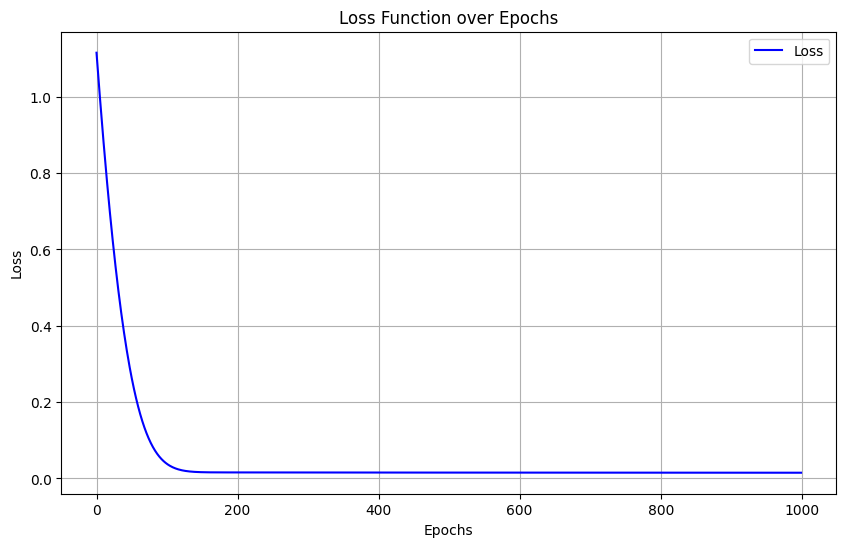

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(train_history, label='Loss', color='b')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Function over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [90]:
def extract_model_params(model):
    """
        Функция извлечения параметров нейросети.
        @param model модель, из которой необходимо извлеч параметры
        @returns 4 объекта типа numpy.array: смещения 1-го слоя, веса 1-го слоя,
                 смещения 2-го слоя, веса 2-го слоя
    """
    # detach() - возвращает выбранный параметр, numpy() конвертирует в формат numpy.array,
    # flatten() для весов преобразует векторы-столбцы в векторы-строки.
    b1 = model.input_hidden_layer.bias.detach().numpy() 
    w1 = model.input_hidden_layer.weight.detach().numpy().flatten()
    b2 = model.output_layer.bias.detach().numpy() 
    w2 = model.output_layer.weight.detach().numpy().flatten()
    
    return b1, w1, b2, w2

In [92]:
b1, w1, b2, w2 = extract_model_params(model)
b1.shape, w1.shape, b2.shape, w2.shape

((20,), (40,), (1,), (20,))